# gans-upscaler

Use the "Run" button to execute the code.

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/jessicali9530/celeba-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shubhammallikthakur
Your Kaggle Key: ··········


  1%|          | 9.00M/1.33G [00:00<00:15, 92.1MB/s]

100%|██████████| 1.33G/1.33G [00:05<00:00, 258MB/s]


In [ ]:
import os
from PIL import Image
import PIL
import glob
import matplotlib.pylab as plt
def name(index):
    return '{0:0=6d}.jpg'.format(index)

In [ ]:
def name1(index):
    return '{0:0=6d}.png'.format(index)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
os.makedirs('faces', exist_ok=True)
os.makedirs('faces/high_res/high_res', exist_ok=True)
os.makedirs('faces/low_res/low_res', exist_ok=True)

In [ ]:
from skimage import io
from skimage.transform import rescale, resize
#from skimage.color import rgb2gray
from skimage import data
from skimage import img_as_ubyte
for i in tqdm(range(60000)):
    image = io.imread('./celeba-dataset/img_align_celeba/img_align_celeba/'+name(i+1))
    #image = rgb2gray(image)
    image1 = resize(image, (64, 64),
                       anti_aliasing=True)
    image2 = resize(image, (32, 32),
                       anti_aliasing=True)
    io.imsave(os.path.join('./faces/high_res/high_res/', name1(i+1)), img_as_ubyte(image1)) 
    io.imsave(os.path.join('./faces/low_res/low_res/', name1(i+1)), img_as_ubyte(image2)) 

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
#from torchvision.datasets.utils import TensorDataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from torchsummary import summary
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
image_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
high_res = './faces/high_res'
low_res = './faces/low_res'

In [ ]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, root1,root2, transform):
        super().__init__()
        self.root1 = root1
        self.root2 = root2
        self.transform = transform
        self.x = ImageFolder(self.root1,self.transform)
        self.y = ImageFolder(self.root2,self.transform)

    def __len__(self):
        return len(ImageFolder(self.root1))

    def __getitem__(self, idx): 

        return self.x[idx][0], self.y[idx][0]

In [ ]:
dataset=CustomDataset(low_res,high_res,tfms)

In [ ]:
%%time
dataset[0][0]

CPU times: user 1.91 ms, sys: 911 µs, total: 2.82 ms
Wall time: 2.59 ms


tensor([[[ 0.9843,  0.9843,  0.9843,  ..., -0.0196,  0.3490,  0.9216],
         [ 0.9843,  0.9843,  0.9843,  ..., -0.0353,  0.5451,  0.9373],
         [ 0.9922,  0.9843,  0.9843,  ...,  0.0431,  0.7176,  0.9451],
         ...,
         [ 0.4667,  0.3725, -0.0745,  ...,  0.1294,  0.4980,  0.5373],
         [ 0.4980,  0.0588, -0.3569,  ..., -0.0745,  0.0588,  0.1451],
         [ 0.2863, -0.0510, -0.2941,  ..., -0.0588, -0.1137, -0.1451]],

        [[ 0.8039,  0.8039,  0.8039,  ..., -0.3882,  0.0588,  0.7804],
         [ 0.8039,  0.8039,  0.8039,  ..., -0.4118,  0.3020,  0.8353],
         [ 0.8275,  0.8196,  0.8196,  ..., -0.3176,  0.5373,  0.8588],
         ...,
         [-0.0667, -0.0980, -0.4824,  ..., -0.3255,  0.0980,  0.1373],
         [-0.0353, -0.4275, -0.7725,  ..., -0.5608, -0.3804, -0.2784],
         [-0.2392, -0.5765, -0.7412,  ..., -0.6078, -0.6392, -0.6471]],

        [[ 0.5216,  0.5216,  0.5216,  ..., -0.6392, -0.2078,  0.6000],
         [ 0.5216,  0.5216,  0.5216,  ..., -0

In [ ]:
val_size = 500
train_size = len(dataset) - val_size
torch.manual_seed(43)
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(59500, 500)

In [ ]:
def denormalize(img_tensors):
    v=img_tensors
    v[0]=v[0] * stats[1][0] + stats[0][0]
    v[1]=v[1] * stats[1][1] + stats[0][1]
    v[2]=v[2] * stats[1][2] + stats[0][2]
    return v
def show_image(dl,dr):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_xticks([]); ax1.set_yticks([])
    ax1.imshow(denormalize(dl).permute(1, 2, 0))
    ax2.set_xticks([]); ax2.set_yticks([])
    ax2.imshow(denormalize(dr).permute(1, 2, 0))
    
    f.set_figheight(18)
    f.set_figwidth(18)

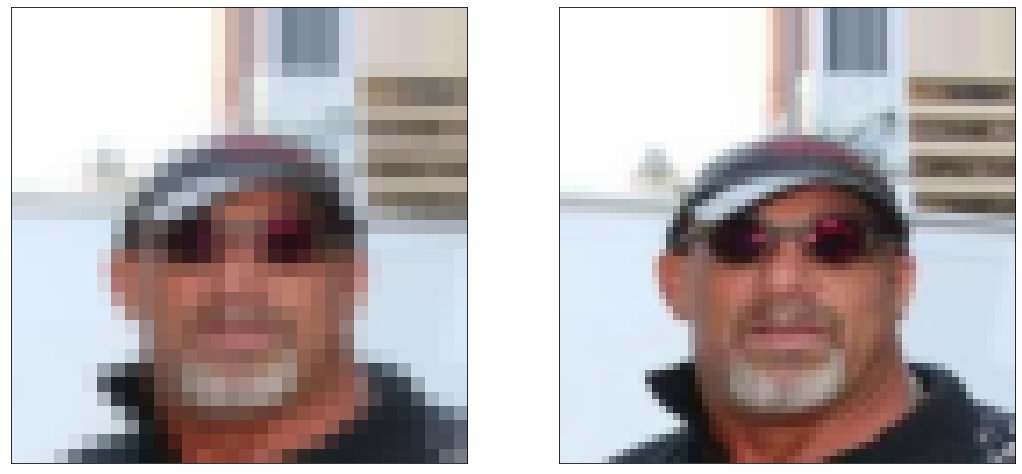

In [ ]:
n=4011
show_image(train_ds[n][0],train_ds[n][1])

In [ ]:
# PyTorch data loaders
batch_size = 100
train_dl = DataLoader(train_ds, batch_size, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [2]:
def conv_blockl(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.LeakyReLU(0.2, inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class discriminator(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.conv1 = conv_blockl(in_channels, 3, pool=False)#3*32*32
        self.conv2 = nn.Sequential(nn.ConvTranspose2d(3, 3, kernel_size=4, stride=2, padding=1, bias=False),
                                   nn.Tanh())#3*64*64
        self.conv3 = conv_blockl(3, 64, pool=True)#64*32*32
        self.conv4 = conv_blockl(64, 128, pool=True)#128*16*16
        self.conv5 = conv_blockl(128, 64, pool=True)#64*8*8
        self.conv6 = conv_blockl(64, 16, pool=True)#16*4*4
        self.conv7 = conv_blockl(16, 3, pool=True)#3*2*2
        self.conv8 = nn.Sequential(conv_blockl(3, 1, pool=True),#1*1*1
                                    #nn.Dropout(0.1),
                                    nn.Flatten(),
                                    nn.Sigmoid())
       
        
    def forward(self, xb,yb):
        out = self.conv1(xb)
        out = self.conv2(out)+yb
        #out = torch.cat((out.view(c.size(0), -1),
                          #yb.view(f.size(0), -1)), dim=1)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
        out = self.conv8(out)
        return out

In [7]:
discriminator = to_device(discriminator(3), device)

In [24]:
summary(discriminator,[(3,32,32),(3,64,64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              84
       BatchNorm2d-2            [-1, 3, 32, 32]               6
         LeakyReLU-3            [-1, 3, 32, 32]               0
   ConvTranspose2d-4            [-1, 3, 64, 64]             144
              Tanh-5            [-1, 3, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]           1,792
       BatchNorm2d-7           [-1, 64, 64, 64]             128
         LeakyReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
      BatchNorm2d-11          [-1, 128, 32, 32]             256
        LeakyReLU-12          [-1, 128, 32, 32]               0
        MaxPool2d-13          [-1, 128, 16, 16]               0
           Conv2d-14           [-1, 64,

In [ ]:
discriminator.load_state_dict(torch.load('upscaler_discriminator3.pth'))

<All keys matched successfully>

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(discriminator)

159921

In [25]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.PReLU()]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=False)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=False)
        self.conv4 = conv_block(256, 128, pool=False)
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.classifier = nn.Sequential(nn.ConvTranspose2d(128, 32, kernel_size=4, stride=2, padding=1, bias=False),
                                        nn.ReLU(True),
                                        nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
                                        nn.Tanh())
                                        
       
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [26]:
generator = to_device(generator(3,3), device)

In [27]:
summary(generator,[(3,32,32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
             PReLU-3           [-1, 64, 32, 32]               1
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
             PReLU-6          [-1, 128, 32, 32]               1
            Conv2d-7          [-1, 128, 32, 32]         147,584
       BatchNorm2d-8          [-1, 128, 32, 32]             256
             PReLU-9          [-1, 128, 32, 32]               1
           Conv2d-10          [-1, 128, 32, 32]         147,584
      BatchNorm2d-11          [-1, 128, 32, 32]             256
            PReLU-12          [-1, 128, 32, 32]               1
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-14          [-1, 256,

In [ ]:
generator.load_state_dict(torch.load('upscaler_generator3.pth'))

<All keys matched successfully>

In [ ]:
count_parameters(generator)

1324779

In [ ]:
def predict_image(img1,img2, model):
    # Convert to a batch of 1
    xb = to_device(img1.unsqueeze(0),device)
    yb = model(xb)
    yb=torch.squeeze(yb)
    print(yb.detach().cpu().shape)
    show_image(img1,yb.detach().cpu())

torch.Size([3, 64, 64])


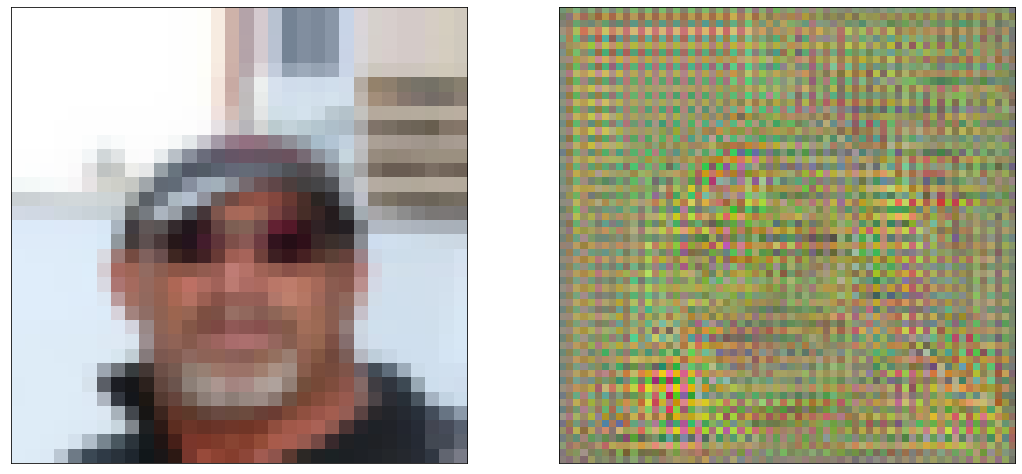

In [ ]:
n=4011
predict_image(train_ds[n][0],train_ds[n][1],generator)

In [ ]:
def train_discriminator(batch, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    inputs, targets = batch
    # Pass real images through discriminator
    real_preds = discriminator(inputs,targets)
    real_targets = torch.ones(inputs.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    fake_images = generator(inputs)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(inputs,fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(batch,opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    inputs,_ = batch
    # Generate fake images
    fake_images = generator(inputs)
    
    # Try to fool the discriminator
    preds = discriminator(inputs,fake_images)
    targets = torch.ones(fake_images.size(0), 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'Upscaled_images_gans'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
image=ImageFolder('./faces/low_res/',tfms)[0][0]

In [ ]:
def save_samples(index,image, show=True):
    img=to_device(image.unsqueeze(0),device)
    img=denormalize(torch.squeeze(generator(img)))
    fake_fname = 'generated-images-{0:0=6d}.png'.format(index)
    save_image(img, os.path.join(sample_dir, fake_fname))
    #save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        show_image(image,img.detach().cpu())

In [ ]:
image.shape

torch.Size([3, 32, 32])

Saving generated-images-000000.png


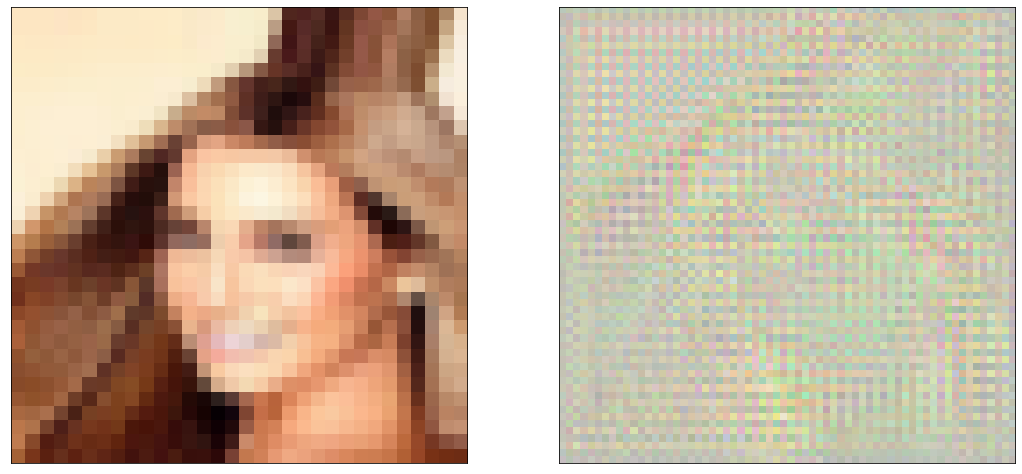

In [ ]:
save_samples(0,image, show=True)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for batch in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(batch, opt_d)
            # Train generator
            loss_g = train_generator(batch,opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, image, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0001
epochs = 25

In [ ]:
%%time
history = fit(epochs, lr)


Epoch [1/25], loss_g: 0.4592, loss_d: 1.1972, real_score: 0.8245, fake_score: 0.6334
Saving generated-images-000001.png



Epoch [2/25], loss_g: 0.4937, loss_d: 1.1540, real_score: 0.8116, fake_score: 0.6112
Saving generated-images-000002.png



Epoch [3/25], loss_g: 0.5232, loss_d: 1.1172, real_score: 0.8039, fake_score: 0.5930
Saving generated-images-000003.png



Epoch [4/25], loss_g: 0.5483, loss_d: 1.0933, real_score: 0.7952, fake_score: 0.5786
Saving generated-images-000004.png



Epoch [5/25], loss_g: 0.5684, loss_d: 1.0690, real_score: 0.7921, fake_score: 0.5665
Saving generated-images-000005.png



Epoch [6/25], loss_g: 0.5852, loss_d: 1.0458, real_score: 0.7935, fake_score: 0.5571
Saving generated-images-000006.png



Epoch [7/25], loss_g: 0.5986, loss_d: 1.0262, real_score: 0.7960, fake_score: 0.5498
Saving generated-images-000007.png



Epoch [8/25], loss_g: 0.6126, loss_d: 1.0027, real_score: 0.8011, fake_score: 0.5420
Saving generated-images-000008.png



Epoch [9/25], loss_g: 0.6255, loss_d: 0.9828, real_score: 0.8050, fake_score: 0.5351
Saving generated-images-000009.png



Epoch [10/25], loss_g: 0.6408, loss_d: 0.9602, real_score: 0.8092, fake_score: 0.5269
Saving generated-images-000010.png



Epoch [11/25], loss_g: 0.6554, loss_d: 0.9392, real_score: 0.8134, fake_score: 0.5194
Saving generated-images-000011.png



Epoch [12/25], loss_g: 0.6702, loss_d: 0.9184, real_score: 0.8173, fake_score: 0.5116
Saving generated-images-000012.png



Epoch [13/25], loss_g: 0.6849, loss_d: 0.8982, real_score: 0.8211, fake_score: 0.5040
Saving generated-images-000013.png



Epoch [14/25], loss_g: 0.6813, loss_d: 1.3853, real_score: 0.5068, fake_score: 0.5061
Saving generated-images-000014.png



Epoch [15/25], loss_g: 0.6916, loss_d: 1.3866, real_score: 0.5007, fake_score: 0.5009
Saving generated-images-000015.png



Epoch [16/25], loss_g: 0.6944, loss_d: 1.3864, real_score: 0.4993, fake_score: 0.4994
Saving generated-images-000016.png



Epoch [17/25], loss_g: 0.6942, loss_d: 1.3865, real_score: 0.4994, fake_score: 0.4995
Saving generated-images-000017.png



Epoch [18/25], loss_g: 0.6943, loss_d: 1.3864, real_score: 0.4993, fake_score: 0.4994
Saving generated-images-000018.png



Epoch [19/25], loss_g: 0.6940, loss_d: 1.3864, real_score: 0.4995, fake_score: 0.4996
Saving generated-images-000019.png



Epoch [20/25], loss_g: 0.6940, loss_d: 1.3864, real_score: 0.4995, fake_score: 0.4996
Saving generated-images-000020.png



Epoch [21/25], loss_g: 0.6939, loss_d: 1.3864, real_score: 0.4996, fake_score: 0.4996
Saving generated-images-000021.png



Epoch [22/25], loss_g: 0.6938, loss_d: 1.3863, real_score: 0.4996, fake_score: 0.4997
Saving generated-images-000022.png



Epoch [23/25], loss_g: 0.6939, loss_d: 1.3863, real_score: 0.4996, fake_score: 0.4996
Saving generated-images-000023.png



Epoch [24/25], loss_g: 0.6938, loss_d: 1.3863, real_score: 0.4997, fake_score: 0.4997
Saving generated-images-000024.png



Epoch [25/25], loss_g: 0.6941, loss_d: 1.3863, real_score: 0.4995, fake_score: 0.4995
Saving generated-images-000025.png
CPU times: user 1h 4min 33s, sys: 52min 12s, total: 1h 56min 46s
Wall time: 1h 56min 54s


In [ ]:
lr = 0.0001
epochs = 25

In [ ]:
%%time
history1 = fit(epochs, lr,26)


Epoch [1/25], loss_g: 0.6586, loss_d: 1.3874, real_score: 0.5208, fake_score: 0.5193
Saving generated-images-000026.png



Epoch [2/25], loss_g: 0.6973, loss_d: 1.3866, real_score: 0.4978, fake_score: 0.4980
Saving generated-images-000027.png



Epoch [3/25], loss_g: 0.6971, loss_d: 1.3861, real_score: 0.4981, fake_score: 0.4980
Saving generated-images-000028.png



Epoch [4/25], loss_g: 0.6989, loss_d: 1.3864, real_score: 0.4971, fake_score: 0.4971
Saving generated-images-000029.png



Epoch [5/25], loss_g: 0.6966, loss_d: 1.3869, real_score: 0.4980, fake_score: 0.4983
Saving generated-images-000030.png



Epoch [6/25], loss_g: 0.6960, loss_d: 1.3865, real_score: 0.4984, fake_score: 0.4986
Saving generated-images-000031.png



Epoch [7/25], loss_g: 0.6948, loss_d: 1.3865, real_score: 0.4991, fake_score: 0.4992
Saving generated-images-000032.png



Epoch [8/25], loss_g: 0.6948, loss_d: 1.3865, real_score: 0.4991, fake_score: 0.4992
Saving generated-images-000033.png



Epoch [9/25], loss_g: 0.6946, loss_d: 1.3864, real_score: 0.4992, fake_score: 0.4993
Saving generated-images-000034.png



Epoch [10/25], loss_g: 0.6942, loss_d: 1.3864, real_score: 0.4994, fake_score: 0.4995
Saving generated-images-000035.png



Epoch [11/25], loss_g: 0.6942, loss_d: 1.3864, real_score: 0.4995, fake_score: 0.4995
Saving generated-images-000036.png



Epoch [12/25], loss_g: 0.6939, loss_d: 1.3864, real_score: 0.4996, fake_score: 0.4996
Saving generated-images-000037.png



Epoch [13/25], loss_g: 0.6949, loss_d: 1.3864, real_score: 0.4991, fake_score: 0.4991
Saving generated-images-000038.png



Epoch [14/25], loss_g: 0.6938, loss_d: 1.3864, real_score: 0.4996, fake_score: 0.4997
Saving generated-images-000039.png



Epoch [15/25], loss_g: 0.6947, loss_d: 1.3863, real_score: 0.4992, fake_score: 0.4992
Saving generated-images-000040.png



Epoch [16/25], loss_g: 0.6949, loss_d: 1.3863, real_score: 0.4991, fake_score: 0.4991
Saving generated-images-000041.png



Epoch [17/25], loss_g: 0.6944, loss_d: 1.3863, real_score: 0.4995, fake_score: 0.4995
Saving generated-images-000042.png



Epoch [18/25], loss_g: 0.6937, loss_d: 1.3863, real_score: 0.4997, fake_score: 0.4997
Saving generated-images-000043.png



Epoch [19/25], loss_g: 0.6936, loss_d: 1.3863, real_score: 0.4998, fake_score: 0.4998
Saving generated-images-000044.png



Epoch [20/25], loss_g: 0.6950, loss_d: 1.3863, real_score: 0.4991, fake_score: 0.4991
Saving generated-images-000045.png



Epoch [21/25], loss_g: 0.6936, loss_d: 1.3863, real_score: 0.4997, fake_score: 0.4997
Saving generated-images-000046.png



Epoch [22/25], loss_g: 0.6950, loss_d: 1.4499, real_score: 0.7449, fake_score: 0.6765
Saving generated-images-000047.png



Epoch [23/25], loss_g: 0.7005, loss_d: 1.3870, real_score: 0.4961, fake_score: 0.4964
Saving generated-images-000048.png



Epoch [24/25], loss_g: 0.6997, loss_d: 1.3868, real_score: 0.4965, fake_score: 0.4967
Saving generated-images-000049.png



Epoch [25/25], loss_g: 0.6985, loss_d: 1.3868, real_score: 0.4971, fake_score: 0.4973
Saving generated-images-000050.png
CPU times: user 1h 4min 40s, sys: 52min 15s, total: 1h 56min 55s
Wall time: 1h 57min 7s


In [ ]:
lr = 0.00001
epochs = 10

In [ ]:
%%time
history2 = fit(epochs, lr,51)


Epoch [1/10], loss_g: 0.6960, loss_d: 1.3863, real_score: 0.4986, fake_score: 0.4986
Saving generated-images-000051.png



Epoch [2/10], loss_g: 0.6897, loss_d: 1.3860, real_score: 0.5019, fake_score: 0.5018
Saving generated-images-000052.png



Epoch [3/10], loss_g: 0.6896, loss_d: 1.3861, real_score: 0.5018, fake_score: 0.5017
Saving generated-images-000053.png



Epoch [4/10], loss_g: 0.6898, loss_d: 1.3860, real_score: 0.5020, fake_score: 0.5018
Saving generated-images-000054.png



Epoch [5/10], loss_g: 0.6891, loss_d: 1.3861, real_score: 0.5022, fake_score: 0.5021
Saving generated-images-000055.png



Epoch [6/10], loss_g: 0.6907, loss_d: 1.3862, real_score: 0.5016, fake_score: 0.5015
Saving generated-images-000056.png



Epoch [7/10], loss_g: 0.6908, loss_d: 1.3861, real_score: 0.5013, fake_score: 0.5012
Saving generated-images-000057.png



Epoch [8/10], loss_g: 0.6923, loss_d: 1.3861, real_score: 0.5006, fake_score: 0.5005
Saving generated-images-000058.png



Epoch [9/10], loss_g: 0.6883, loss_d: 1.3861, real_score: 0.5027, fake_score: 0.5025
Saving generated-images-000059.png



Epoch [10/10], loss_g: 0.6880, loss_d: 1.3859, real_score: 0.5029, fake_score: 0.5027
Saving generated-images-000060.png
CPU times: user 25min 52s, sys: 20min 55s, total: 46min 47s
Wall time: 46min 51s


In [ ]:
lr = 0.00001
epochs = 25

In [ ]:
%%time
history3 = fit(epochs, lr,61)


Epoch [1/25], loss_g: 0.6883, loss_d: 1.3861, real_score: 0.5027, fake_score: 0.5026
Saving generated-images-000061.png



Epoch [2/25], loss_g: 0.6871, loss_d: 1.3864, real_score: 0.5032, fake_score: 0.5032
Saving generated-images-000062.png



Epoch [3/25], loss_g: 0.6867, loss_d: 1.3865, real_score: 0.5032, fake_score: 0.5033
Saving generated-images-000063.png



Epoch [4/25], loss_g: 0.6851, loss_d: 1.3866, real_score: 0.5040, fake_score: 0.5041
Saving generated-images-000064.png



Epoch [5/25], loss_g: 0.6874, loss_d: 1.3865, real_score: 0.5027, fake_score: 0.5028
Saving generated-images-000065.png



Epoch [6/25], loss_g: 0.6845, loss_d: 1.3865, real_score: 0.5042, fake_score: 0.5042
Saving generated-images-000066.png



Epoch [7/25], loss_g: 0.6864, loss_d: 1.3866, real_score: 0.5032, fake_score: 0.5033
Saving generated-images-000067.png



Epoch [8/25], loss_g: 0.6840, loss_d: 1.3866, real_score: 0.5045, fake_score: 0.5046
Saving generated-images-000068.png



Epoch [9/25], loss_g: 0.6834, loss_d: 1.3870, real_score: 0.5049, fake_score: 0.5051
Saving generated-images-000069.png



Epoch [10/25], loss_g: 0.6853, loss_d: 1.3866, real_score: 0.5040, fake_score: 0.5041
Saving generated-images-000070.png



Epoch [11/25], loss_g: 0.6830, loss_d: 1.3872, real_score: 0.5057, fake_score: 0.5060
Saving generated-images-000071.png



Epoch [12/25], loss_g: 0.6833, loss_d: 1.3878, real_score: 0.5060, fake_score: 0.5065
Saving generated-images-000072.png



Epoch [13/25], loss_g: 0.6836, loss_d: 1.3873, real_score: 0.5059, fake_score: 0.5062
Saving generated-images-000073.png



Epoch [14/25], loss_g: 0.6865, loss_d: 1.3866, real_score: 0.5042, fake_score: 0.5042
Saving generated-images-000074.png



Epoch [15/25], loss_g: 0.6831, loss_d: 1.3860, real_score: 0.5062, fake_score: 0.5059
Saving generated-images-000075.png



Epoch [16/25], loss_g: 0.6856, loss_d: 1.3861, real_score: 0.5047, fake_score: 0.5044
Saving generated-images-000076.png



Epoch [17/25], loss_g: 0.6850, loss_d: 1.3863, real_score: 0.5048, fake_score: 0.5045
Saving generated-images-000077.png



Epoch [18/25], loss_g: 0.6746, loss_d: 1.3861, real_score: 0.5111, fake_score: 0.5104
Saving generated-images-000078.png



Epoch [19/25], loss_g: 0.6780, loss_d: 1.3852, real_score: 0.5089, fake_score: 0.5078
Saving generated-images-000079.png



Epoch [20/25], loss_g: 0.6778, loss_d: 1.3862, real_score: 0.5092, fake_score: 0.5086
Saving generated-images-000080.png



Epoch [21/25], loss_g: 0.6767, loss_d: 1.3859, real_score: 0.5109, fake_score: 0.5099
Saving generated-images-000081.png



Epoch [22/25], loss_g: 0.6733, loss_d: 1.3879, real_score: 0.5111, fake_score: 0.5112
Saving generated-images-000082.png



Epoch [23/25], loss_g: 0.6742, loss_d: 1.3875, real_score: 0.5134, fake_score: 0.5131
Saving generated-images-000083.png



Epoch [24/25], loss_g: 0.6701, loss_d: 1.3866, real_score: 0.5148, fake_score: 0.5139
Saving generated-images-000084.png



Epoch [25/25], loss_g: 0.6804, loss_d: 1.3866, real_score: 0.5102, fake_score: 0.5096
Saving generated-images-000085.png
CPU times: user 1h 3min 26s, sys: 40min 48s, total: 1h 44min 15s
Wall time: 1h 44min 42s


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
losses_g1, losses_d1, real_scores1, fake_scores1 = history1

In [ ]:
losses_g2, losses_d2, real_scores2, fake_scores2 = history2

torch.Size([3, 64, 64])


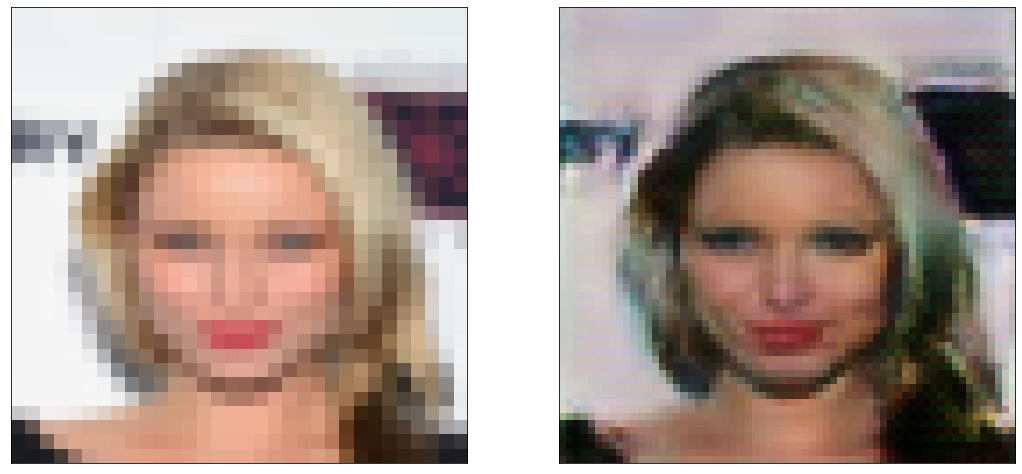

In [ ]:
n=4070
predict_image(train_ds[n][0],train_ds[n][1],generator)

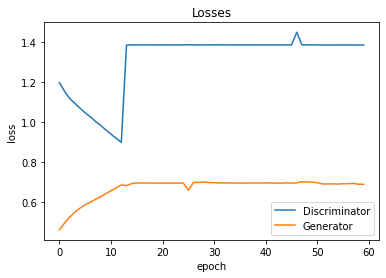

In [ ]:
plt.plot(losses_d+losses_d1+losses_d2, '-')
plt.plot(losses_g+losses_g1+losses_g2, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

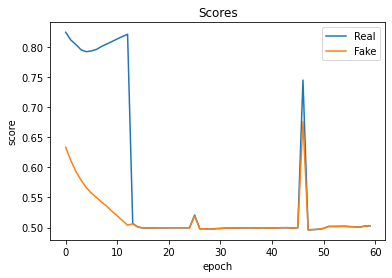

In [ ]:
plt.plot(real_scores+real_scores1+real_scores2, '-')
plt.plot(fake_scores+fake_scores1+fake_scores2, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
torch.save(generator.state_dict(), 'upscaler_generator3.pth')
torch.save(discriminator.state_dict(), 'upscaler_discriminator3.pth')

In [ ]:
import cv2
import os

vid_fname = 'gans_training2.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()